# 07 — Quality Assessment

Score every segmented rep on three criteria (back alignment, depth, extension), compare correct vs incorrect form, validate scoring cutoffs, and generate text feedback.

Uses the same 95 reps from notebook 06.

In [1]:
import sys
sys.path.insert(0, "..")

import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

from src.quality.scoring import QualityScorer
from src.quality.feedback import generate_feedback
from src.classification.rep_segmenter import segment_all_videos, compute_rep_features

# Load manifest and segment reps (same thresholds as notebook 06)
with open("../data/processed/keypoints/manifest.json") as f:
    manifest = json.load(f)

KEYPOINT_DIR = Path("../data/processed/keypoints/yolo")
DOWN_THRESHOLD = 110.0
UP_THRESHOLD = 145.0

rep_segments = segment_all_videos(
    manifest, KEYPOINT_DIR,
    down_threshold=DOWN_THRESHOLD,
    up_threshold=UP_THRESHOLD,
)

print(f"Total reps: {len(rep_segments)}")
print(f"  Correct: {sum(1 for r in rep_segments if r['label'] == 0)}")
print(f"  Incorrect: {sum(1 for r in rep_segments if r['label'] == 1)}")

Total reps: 95
  Correct: 47
  Incorrect: 48


## Section 1: Score All Reps

Run `QualityScorer` on every rep and build a DataFrame with per-criterion and composite scores.

In [2]:
scorer = QualityScorer()

rows = []
for rep in rep_segments:
    score = scorer.score_rep(rep["keypoints"])
    rows.append({
        "video_id": rep["video_id"],
        "rep_idx": rep["rep_idx"],
        "label": "correct" if rep["label"] == 0 else "incorrect",
        "n_frames": rep["end_frame"] - rep["start_frame"] + 1,
        "back_alignment": round(score.back_alignment, 1),
        "depth": round(score.depth, 1),
        "extension": round(score.extension, 1),
        "composite": round(score.composite, 1),
    })

df = pd.DataFrame(rows)
print(f"Scored {len(df)} reps\n")
print(df.groupby("label")[["back_alignment", "depth", "extension", "composite"]].describe().round(1).to_string())
print()
print(df.head(10).to_string(index=False))

Scored 95 reps

          back_alignment                                          depth                                             extension                                            composite                                         
                   count  mean  std   min   25%   50%   75%   max count  mean  std   min   25%    50%    75%    max     count  mean   std   min   25%   50%   75%    max     count  mean  std   min   25%   50%   75%   max
label                                                                                                                                                                                                                      
correct             47.0  84.0  9.0  52.1  81.7  86.1  89.8  95.5  47.0  96.7  7.0  72.0  97.8  100.0  100.0  100.0      47.0  65.0  12.4  50.3  53.6  61.0  76.7   87.0      47.0  83.7  6.4  63.6  82.0  84.4  87.5  92.8
incorrect           48.0  83.3  9.1  44.8  78.4  85.2  89.6  96.4  48.0  94.2  8.4  73.1  88.1  100.0  1

## Section 2: Score Distributions — Correct vs Incorrect

Box plots and histograms for each criterion, split by label. If the scorer is meaningful, correct reps should score higher.

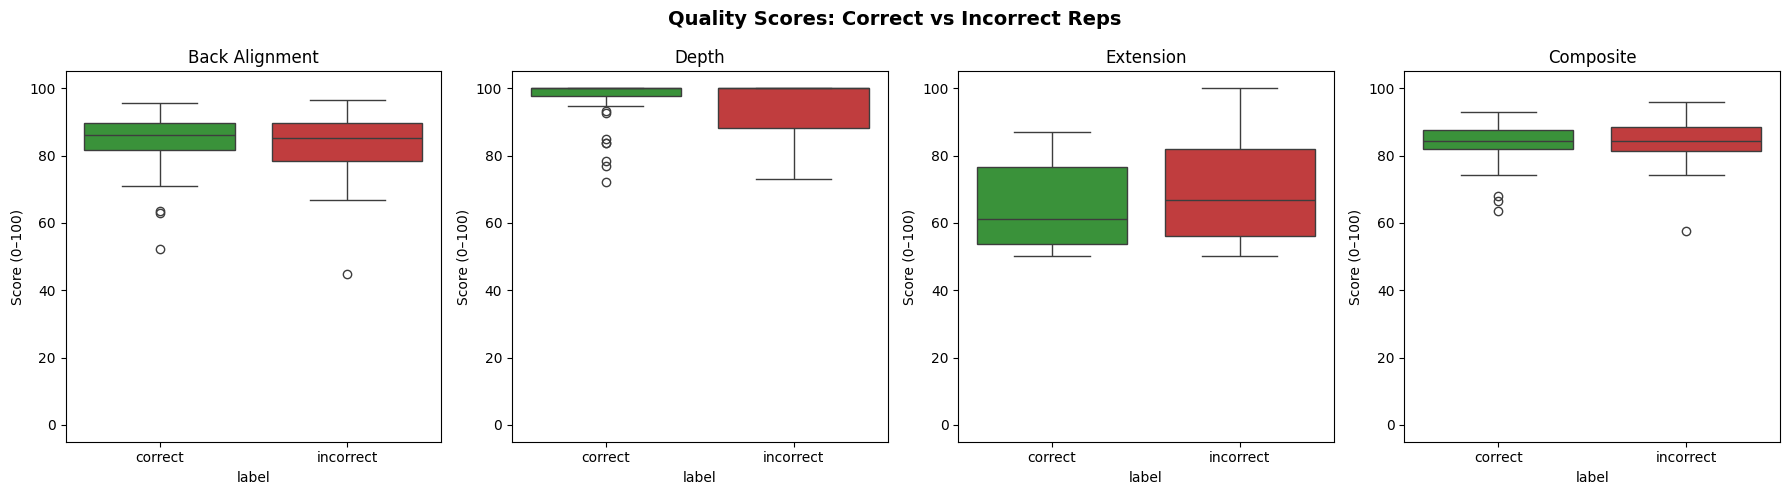

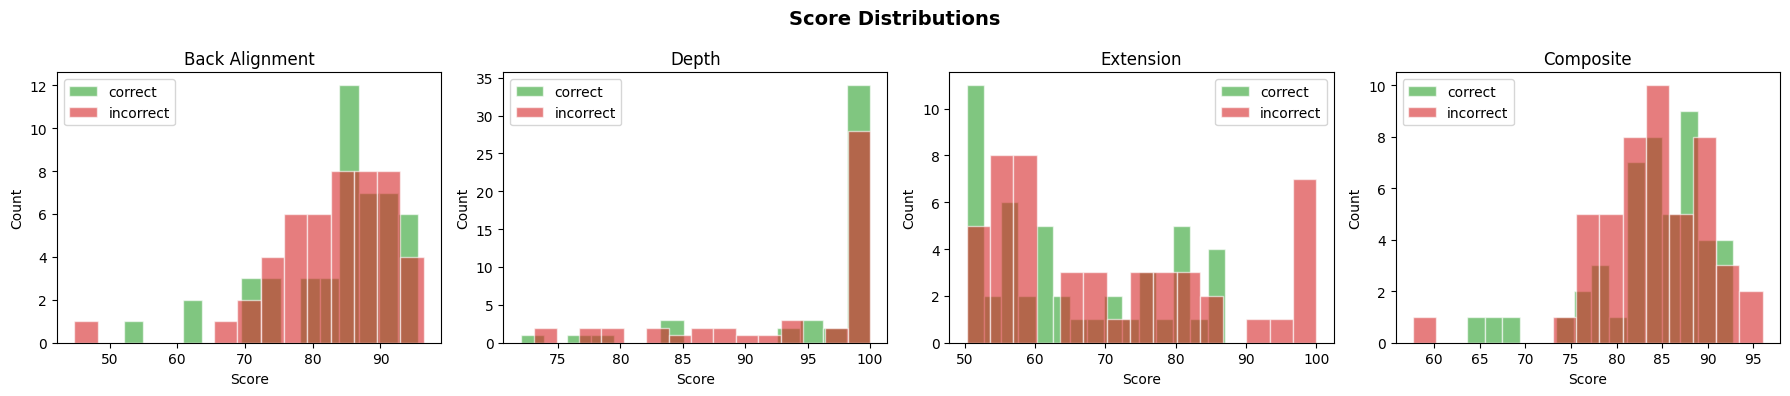

Mean scores by label:
           back_alignment  depth  extension  composite
label                                                 
correct              84.0   96.7       65.0       83.7
incorrect            83.3   94.2       70.7       84.0


In [3]:
criteria = ["back_alignment", "depth", "extension", "composite"]
palette = {"correct": "#2ca02c", "incorrect": "#d62728"}

# Box plots
fig, axes = plt.subplots(1, 4, figsize=(18, 5))
for i, col in enumerate(criteria):
    sns.boxplot(data=df, x="label", y=col, ax=axes[i], palette=palette, hue="label", legend=False)
    axes[i].set_title(col.replace("_", " ").title())
    axes[i].set_ylabel("Score (0–100)")
    axes[i].set_ylim(-5, 105)
plt.suptitle("Quality Scores: Correct vs Incorrect Reps", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig("../outputs/figures/07_score_boxplots.png", dpi=150, bbox_inches="tight")
plt.show()

# Histograms
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
for i, col in enumerate(criteria):
    for label, color in palette.items():
        subset = df[df["label"] == label][col]
        axes[i].hist(subset, bins=15, alpha=0.6, label=label, color=color, edgecolor="white")
    axes[i].set_title(col.replace("_", " ").title())
    axes[i].set_xlabel("Score")
    axes[i].set_ylabel("Count")
    axes[i].legend()
plt.suptitle("Score Distributions", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig("../outputs/figures/07_score_histograms.png", dpi=150, bbox_inches="tight")
plt.show()

# Mean scores summary
print("Mean scores by label:")
print(df.groupby("label")[criteria].mean().round(1).to_string())

## Section 3: Composite Score as a Classifier

Can the composite score alone classify reps? Sweep thresholds and find the best cutoff. Compare to the ST-GCN classifier.

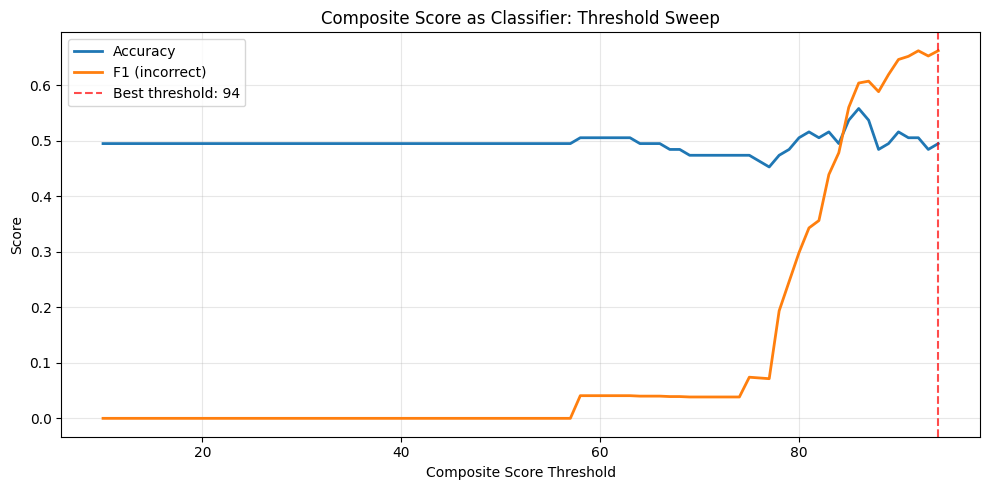

Best composite threshold: 94
  Accuracy: 0.4947
  F1 (incorrect): 0.6620


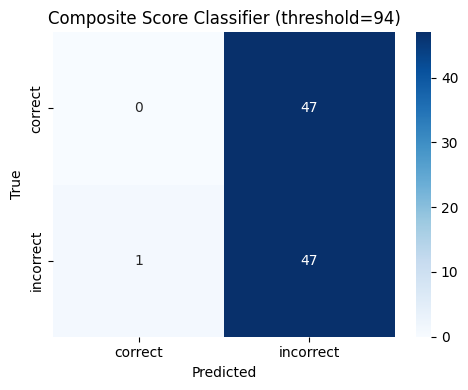

In [4]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc

y_true = (df["label"] == "incorrect").astype(int).values  # 1=incorrect, 0=correct
composite = df["composite"].values

# Sweep composite thresholds: reps scoring below threshold = "incorrect"
thresholds = np.arange(10, 95, 1)
accs = []
f1s = []
for th in thresholds:
    preds = (composite < th).astype(int)  # below threshold = incorrect
    accs.append(accuracy_score(y_true, preds))
    f1s.append(f1_score(y_true, preds))

best_idx = np.argmax(f1s)
best_th = thresholds[best_idx]
best_acc = accs[best_idx]
best_f1 = f1s[best_idx]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(thresholds, accs, label="Accuracy", linewidth=2)
ax.plot(thresholds, f1s, label="F1 (incorrect)", linewidth=2)
ax.axvline(best_th, color="red", linestyle="--", alpha=0.7, label=f"Best threshold: {best_th}")
ax.set_xlabel("Composite Score Threshold")
ax.set_ylabel("Score")
ax.set_title("Composite Score as Classifier: Threshold Sweep")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../outputs/figures/07_threshold_sweep.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"Best composite threshold: {best_th}")
print(f"  Accuracy: {best_acc:.4f}")
print(f"  F1 (incorrect): {best_f1:.4f}")

# Confusion matrix at best threshold
preds_best = (composite < best_th).astype(int)
cm = confusion_matrix(y_true, preds_best)
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["correct", "incorrect"],
            yticklabels=["correct", "incorrect"], ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title(f"Composite Score Classifier (threshold={best_th})")
plt.tight_layout()
plt.savefig("../outputs/figures/07_composite_confusion.png", dpi=150, bbox_inches="tight")
plt.show()

## Section 4: Per-Criterion Separability

Which criterion best separates correct from incorrect? ROC curves for each criterion individually.

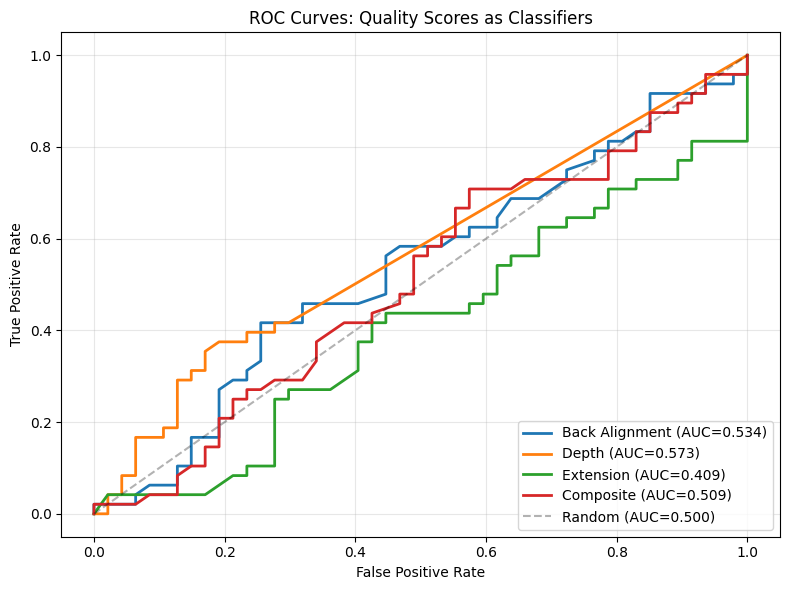

In [5]:
# ROC curves per criterion (higher score = more likely correct, so invert for "incorrect" detection)
fig, ax = plt.subplots(figsize=(8, 6))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

for col, color in zip(criteria, colors):
    scores = df[col].values
    # Lower score → more likely incorrect, so negate for ROC
    fpr, tpr, _ = roc_curve(y_true, -scores)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color, linewidth=2,
            label=f"{col.replace('_', ' ').title()} (AUC={roc_auc:.3f})")

ax.plot([0, 1], [0, 1], "k--", alpha=0.3, label="Random (AUC=0.500)")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curves: Quality Scores as Classifiers")
ax.legend(loc="lower right")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../outputs/figures/07_roc_curves.png", dpi=150, bbox_inches="tight")
plt.show()

## Section 5: Cross-Reference with ST-GCN Classifier

Load the classification results from notebook 06 and compare: do the quality scores agree with the ST-GCN predictions?

Merged 95 reps with both quality scores and ST-GCN predictions


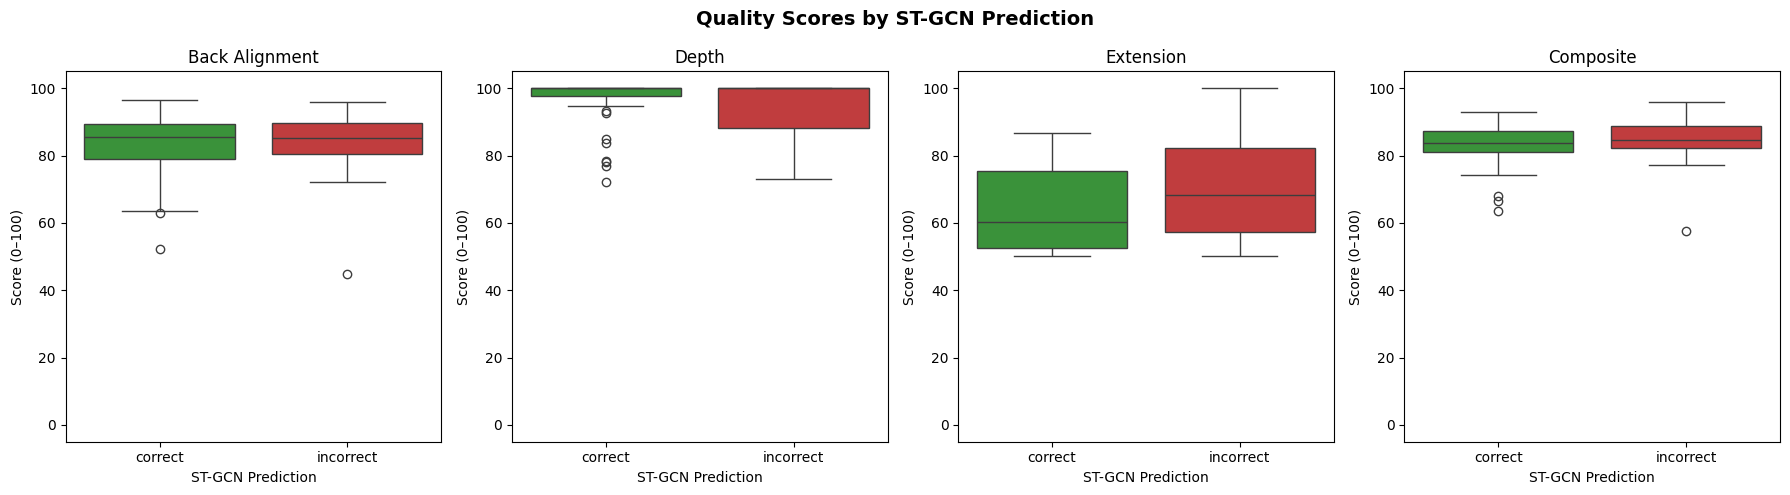


Mean composite score by ST-GCN prediction:
            mean  median  std
stgcn_pred                   
correct     83.0    83.7  6.4
incorrect   84.6    84.6  6.0


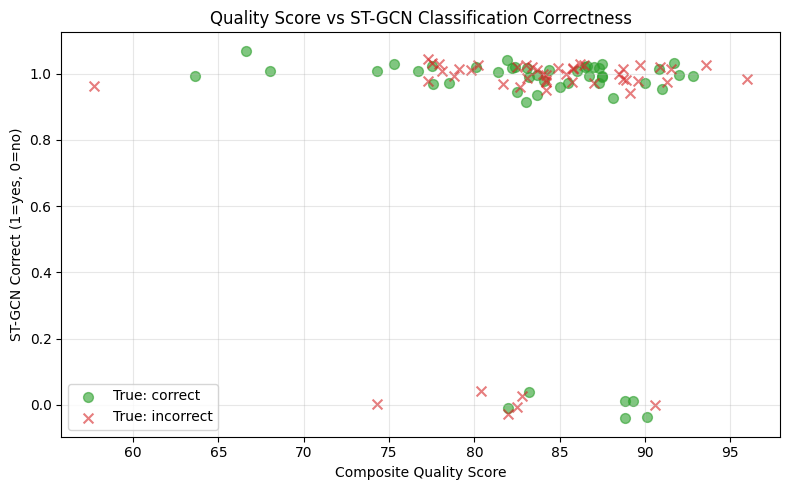

In [6]:
# Load notebook 06 classification results
RESULTS_DIR = Path("../outputs/results")
df_class = pd.read_csv(RESULTS_DIR / "form_classification_results.csv")

# Merge quality scores with classification predictions
df_merged = df.merge(
    df_class[["video_id", "rep_idx", "stgcn_pred", "stgcn_correct"]],
    on=["video_id", "rep_idx"],
    how="inner",
)
print(f"Merged {len(df_merged)} reps with both quality scores and ST-GCN predictions")

# Compare: quality scores for ST-GCN correct vs incorrect predictions
fig, axes = plt.subplots(1, 4, figsize=(18, 5))
for i, col in enumerate(criteria):
    sns.boxplot(
        data=df_merged, x="stgcn_pred", y=col, ax=axes[i],
        palette={"correct": "#2ca02c", "incorrect": "#d62728"},
        hue="stgcn_pred", legend=False,
        order=["correct", "incorrect"],
    )
    axes[i].set_title(col.replace("_", " ").title())
    axes[i].set_ylabel("Score (0–100)")
    axes[i].set_xlabel("ST-GCN Prediction")
    axes[i].set_ylim(-5, 105)
plt.suptitle("Quality Scores by ST-GCN Prediction", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig("../outputs/figures/07_scores_by_stgcn.png", dpi=150, bbox_inches="tight")
plt.show()

# Agreement: do low-scoring reps get classified as incorrect?
print("\nMean composite score by ST-GCN prediction:")
print(df_merged.groupby("stgcn_pred")["composite"].agg(["mean", "median", "std"]).round(1).to_string())

# Scatter: composite score vs ST-GCN correctness
fig, ax = plt.subplots(figsize=(8, 5))
for label, color in palette.items():
    subset = df_merged[df_merged["label"] == label]
    marker = "o" if label == "correct" else "x"
    ax.scatter(
        subset["composite"], subset["stgcn_correct"].astype(float) + np.random.normal(0, 0.03, len(subset)),
        alpha=0.6, color=color, label=f"True: {label}", marker=marker, s=50,
    )
ax.set_xlabel("Composite Quality Score")
ax.set_ylabel("ST-GCN Correct (1=yes, 0=no)")
ax.set_title("Quality Score vs ST-GCN Classification Correctness")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../outputs/figures/07_score_vs_stgcn.png", dpi=150, bbox_inches="tight")
plt.show()

## Section 6: Text Feedback Examples

Show generated feedback for a sample of correct and incorrect reps.

In [7]:
# Show feedback for best correct, worst correct, best incorrect, worst incorrect
print("=" * 60)
for desc, subset_df in [
    ("BEST correct rep", df[df["label"] == "correct"].nlargest(1, "composite")),
    ("WORST correct rep", df[df["label"] == "correct"].nsmallest(1, "composite")),
    ("BEST incorrect rep", df[df["label"] == "incorrect"].nlargest(1, "composite")),
    ("WORST incorrect rep", df[df["label"] == "incorrect"].nsmallest(1, "composite")),
]:
    row = subset_df.iloc[0]
    rep = next(r for r in rep_segments
               if r["video_id"] == row["video_id"] and r["rep_idx"] == row["rep_idx"])
    score = scorer.score_rep(rep["keypoints"])
    feedback = generate_feedback(score)

    print(f"\n{desc}: {row['video_id']} rep {row['rep_idx']}")
    print(f"  Back: {score.back_alignment:.0f}  Depth: {score.depth:.0f}  "
          f"Extension: {score.extension:.0f}  Composite: {score.composite:.0f}")
    for line in feedback:
        print(f"  → {line}")
    print("-" * 60)

# Show a random sample of 5 reps with their feedback
print("\n\nRANDOM SAMPLE OF 5 REPS:")
print("=" * 60)
rng = np.random.default_rng(42)
sample_idx = rng.choice(len(rep_segments), size=5, replace=False)

for idx in sample_idx:
    rep = rep_segments[idx]
    score = scorer.score_rep(rep["keypoints"])
    feedback = generate_feedback(score)
    label = "correct" if rep["label"] == 0 else "incorrect"

    print(f"\n{rep['video_id']} rep {rep['rep_idx']} (true: {label})")
    print(f"  Back: {score.back_alignment:.0f}  Depth: {score.depth:.0f}  "
          f"Extension: {score.extension:.0f}  Composite: {score.composite:.0f}")
    for line in feedback:
        print(f"  → {line}")
    print("-" * 60)


BEST correct rep: correct__Copy_of_push_up_114 rep 0
  Back: 93  Depth: 100  Extension: 82  Composite: 93
  → Excellent form! Keep it up.
------------------------------------------------------------

WORST correct rep: correct__Copy_of_push_up_1 rep 0
  Back: 52  Depth: 84  Extension: 54  Composite: 64
  → Decent effort — focus on the areas below to improve.
  → Your back alignment could improve. Focus on maintaining a straight line from shoulders to ankles.
  → Almost full extension at the top — push up a little more.
------------------------------------------------------------

BEST incorrect rep: incorrect__8 rep 0
  Back: 90  Depth: 100  Extension: 100  Composite: 96
  → Excellent form! Keep it up.
------------------------------------------------------------

WORST incorrect rep: incorrect__Copy_of_push_up_81 rep 0
  Back: 45  Depth: 78  Extension: 50  Composite: 58
  → Decent effort — focus on the areas below to improve.
  → Keep your back straight — avoid sagging your hips or pi

## Section 7: Save Results

In [8]:
RESULTS_DIR = Path("../outputs/results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Save quality scores
df.to_csv(RESULTS_DIR / "quality_scores.csv", index=False)
print(f"Saved: {RESULTS_DIR / 'quality_scores.csv'} ({len(df)} reps)")

# Save merged quality + classification results
if len(df_merged) > 0:
    df_merged.to_csv(RESULTS_DIR / "quality_classification_merged.csv", index=False)
    print(f"Saved: {RESULTS_DIR / 'quality_classification_merged.csv'} ({len(df_merged)} reps)")

# Summary
print(f"\n=== Quality Assessment Summary ===")
print(f"Reps scored: {len(df)}")
print(f"Best composite threshold for classification: {best_th} (acc={best_acc:.1%}, F1={best_f1:.3f})")
print(f"\nMean composite scores:")
for label in ["correct", "incorrect"]:
    mean = df[df["label"] == label]["composite"].mean()
    print(f"  {label}: {mean:.1f}")

Saved: ../outputs/results/quality_scores.csv (95 reps)
Saved: ../outputs/results/quality_classification_merged.csv (95 reps)

=== Quality Assessment Summary ===
Reps scored: 95
Best composite threshold for classification: 94 (acc=49.5%, F1=0.662)

Mean composite scores:
  correct: 83.7
  incorrect: 84.0
